In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import gc

Решение уравнения Гельмгольца $-\Delta \varphi + \mu \varphi = f$ where $\mu \geq 0$ через синус-преобразование 1-го типа с помощью библиотеки Pytorch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def plot_imshow_comparison(phi, exact_solution, titles=["Численное решение", "Точное решение"]):
    """
    Рисует тепловую карту численного решения, точного решения и их разности.
    Параметры:
        phi (2D torch.Tensor) – численное решение
        exact_solution (2D torch.Tensor) – точное решение
        titles: (list) Список из двух строк с заголовками графиков
    """
    
    fig = plt.figure(figsize=(18, 6))

    ax1 = fig.add_subplot(131, )
    im1 = ax1.imshow(phi.T, cmap='viridis', interpolation='bilinear',
               extent=[0, 1, 0, 1], origin='lower')
    fig.colorbar(im1, ax=ax1, label='φ_h(x, y)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(titles[0])

    ax2 = fig.add_subplot(132)
    im2 = ax2.imshow(exact_solution.T, cmap='viridis', interpolation='bilinear',
               extent=[0, 1, 0, 1], origin='lower')
    fig.colorbar(im2, ax=ax2, label='(φ)_h')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title(titles[1])

    ax3 = fig.add_subplot(133)
    im3 = ax3.imshow(phi.T - exact_solution.T, cmap='viridis', interpolation='bilinear',
               extent=[0, 1, 0, 1], origin='lower')
    fig.colorbar(im3, ax=ax3, label='φ_h - (φ)_h')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title("Разность")

    plt.tight_layout()
    plt.show()

def plot_imshow_solution(phi, title='Численное решение'):
    """
    Рисует тепловую карту численного решения.
    Параметры:
        phi (2D torch.Tensor): численное решение
        title (str): заголовок графика
    """
    
    plt.imshow(phi.T, cmap='viridis', interpolation='bilinear', extent=[0, 1, 0, 1], origin='lower')
    plt.colorbar(label='φ(x,y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    
    plt.show()
    
def plot_3d_solution(X, Y, phi, title="Численное решение"):
    """
    Рисует 3D график численного решения.
    Параметры:
        X, Y: сетка на прямоугольнике, построенная с помощью meshgrid
        phi (2D torch.Tensor): численное решение
        title (str): заголовок графика
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, phi, cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('φ(x, y)')
    ax.set_title(title)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

def plot_3d_comparison(X, Y, phi, exact_solution, titles=["Численное решение", "Точное решение"]):
    """
    Рисует 3D график численного решения и точного решения
    Параметры:
        X, Y: сетка на прямоугольнике, построенная с помощью meshgrid
        phi (2D torch.Tensor) – численное решение
        exact_solution (2D torch.Tensor) – точное решение
        titles: (list) Список из двух строк с заголовками графиков
    """

    fig = plt.figure(figsize=(18, 6))

    # Численное решение
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, Y, phi, cmap='viridis')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(titles[0])

    # Точное решение
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, Y, exact_solution, cmap='plasma')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title(titles[1])

    # Разница
    """
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X, Y, torch.abs(phi - exact_solution), cmap='hot')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title("Ошибка")
    """

    plt.tight_layout()
    plt.show()

In [ ]:
def dst_I_ortho(x):
    """
    Дискретное синус-преобразование 1-го типа с помощью БДПФ. Аналог scipy.fft.dst(x, type=1, norm='ortho')
    Параметры:
        x (torch.Tensor): одномерный вещественный тензор.
    Возвращает:
        torch.Tensor: синус-преобразование х. Одномерный вещественный тензор
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    x = x.to(device)
    d = len(x)
    w = torch.cat([torch.zeros(1, device=device), x, torch.zeros(1, device=device), -torch.flip(x, dims=[0])])
    return - torch.fft.fft(w).imag[1:d+1] / np.sqrt(2 * (d+1))

In [ ]:
def solve_helmholtz(mu, f, h):
    N = f.shape[0] - 1
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Подготовка правой части (внутренние точки)
    f_internal = f[1:-1, 1:-1].to(device)

    # Двойное DST-I преобразование
    F = torch.zeros((N-1, N-1), device=device)
    for j in range(N-1):
        F[:, j] = dst_I_ortho(f_internal[:, j])
    for i in range(N-1):
        F[i, :] = dst_I_ortho(F[i, :])

    # Вычисление собственных значений 2D оператора
    k = np.pi * torch.arange(1, N, device=device) 
    lambda_kl = (4/h**2)*(torch.sin(k*h/2)**2).reshape(-1,1) + \
                (4/h**2)*(torch.sin(k*h/2)**2) + mu

    # Решение в частотной области
    Phi = F / lambda_kl

    # Обратное двойное DST-I
    phi_internal = torch.zeros((N-1, N-1), device=device)
    for j in range(N-1):
        phi_internal[:, j] = dst_I_ortho(Phi[:, j])
    for i in range(N-1):
        phi_internal[i, :] = dst_I_ortho(phi_internal[i, :])
    # 
    phi = torch.zeros((N+1, N+1), device=device)
    phi[1:-1, 1:-1] = phi_internal
    return phi

In [ ]:
# Параметры

# При N = 2^14 на GPU Р100 время выполнения 15 секунд, на CPU kaggle время выполнения 2 минуты
# При N = 2^8 на CPU считается за 0.25 секунды, на GPU за 0.5 секунды 
# при N = 2^15 уже не влезает в 16 Гб памяти. 
N = 2 ** 10 
h = 1.0 / N
mu = 1.0

# Сетка
x = torch.linspace(0, 1, N+1).to(device)
y = torch.linspace(0, 1, N+1).to(device)
X, Y = torch.meshgrid(x, y, indexing='ij')

# Тестовые функции

#f = torch.zeros((N+1, N+1), device=device)
#exact_solution = torch.zeros((N+1, N+1), device=device)

#f = 100 * torch.sin(2*np.pi*X) * torch.sin(np.pi*Y)
#exact_solution = f / (4*np.pi**2 + np.pi**2 + mu)  # Аналитическое решение для -Δφ + μφ = 100*sin(2πx)sin(πy)

#f = 1000 * torch.sin(2*np.pi*X) * torch.sin(np.pi*Y)
#exact_solution = f / (4*np.pi**2 + np.pi**2 + mu)  # Аналитическое решение для -Δφ + μφ = 1000*sin(2πx)sin(πy)

#f = 100 * torch.sin(np.pi * X) * torch.sin(np.pi * Y)
#exact_solution = f / (2 * np.pi ** 2 + mu) # Аналитическое решение для -Δφ + μφ = 100*sin(πx)sin(πy)

#f = 100 * torch.sin(2 * np.pi * X) * torch.sin(2 * np.pi * Y)
#exact_solution = f / (8 * np.pi ** 2 + mu) # Аналитическое решение для -Δφ + μφ = 100*sin(2πx)sin(2πy)

#f = 100 * torch.sin(10 * np.pi * X) * torch.sin(6 * np.pi * Y)
#exact_solution = f / (136 * torch.pi**2 + mu) # Аналитическое решение для -Δφ + μφ = 100*sin(10πx)sin(6πy)

f = - 2 * (Y**2 - Y + X**2 - X) + mu * (X**2 - X) * (Y**2 - Y)
exact_solution = (X * (X - 1) * Y * (Y - 1)) # Аналитическое решение для -Δφ + μφ = -2y(y-1)-2x(x-1)+μxy(x-1)(y-1)


# Численное решение
start_time = time.time()
phi = solve_helmholtz(mu, f, h)
execution_time = time.time() - start_time


# Проверка в точке
"""
i, j = N//4, N//2  # Точка (0.25, 0.5)
print(f"В точке ({i*h:.3f}, {j*h:.3f}):")
print(f"Точное: {exact_solution[i,j]:.6f}")
print(f"Численное: {phi[i,j]:.6f}")
print(f"Отн. ошибка: {abs(phi[i,j]-exact_solution[i,j])/exact_solution[i,j]:.3e}")
"""

# Подсчет погрешности
relative_error = torch.norm(phi - exact_solution)/torch.norm(exact_solution)
abs_error = torch.max(torch.abs(phi - exact_solution))
print(f"Средняя относительная ошибка: {relative_error:.3e}")
print(f"Максимальная абсолютная ошибка: {abs_error:.3e}")
print(f"Время выполнения: {execution_time:.5} c")

Средняя относительная ошибка: 4.934e-07
Максимальная абсолютная ошибка: 6.333e-08
Время выполнения: 0.9578 c


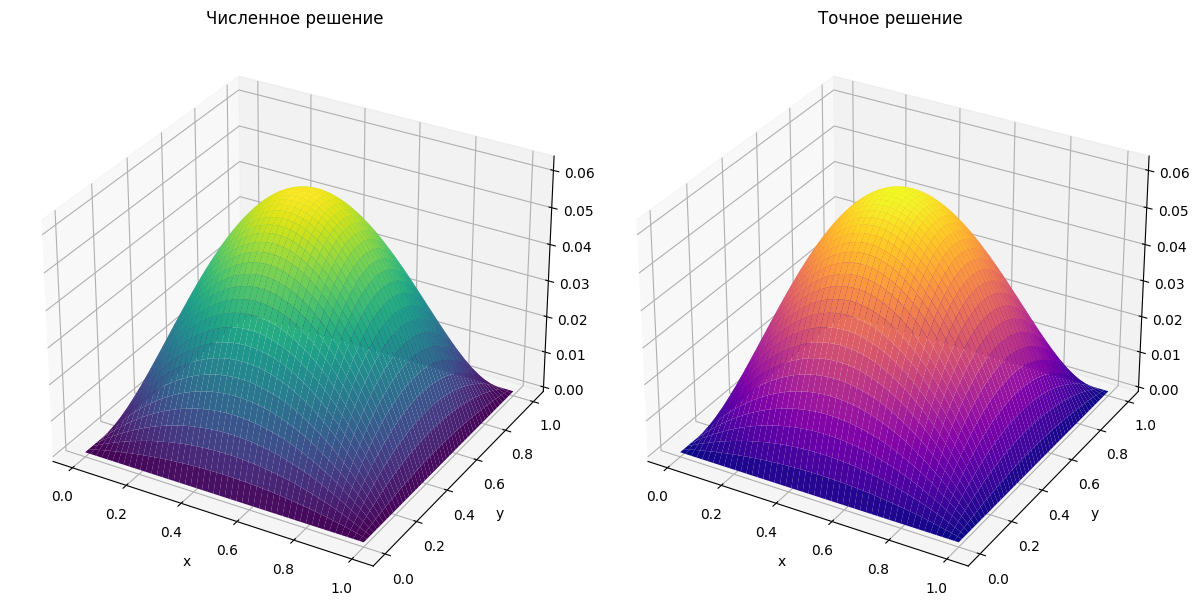

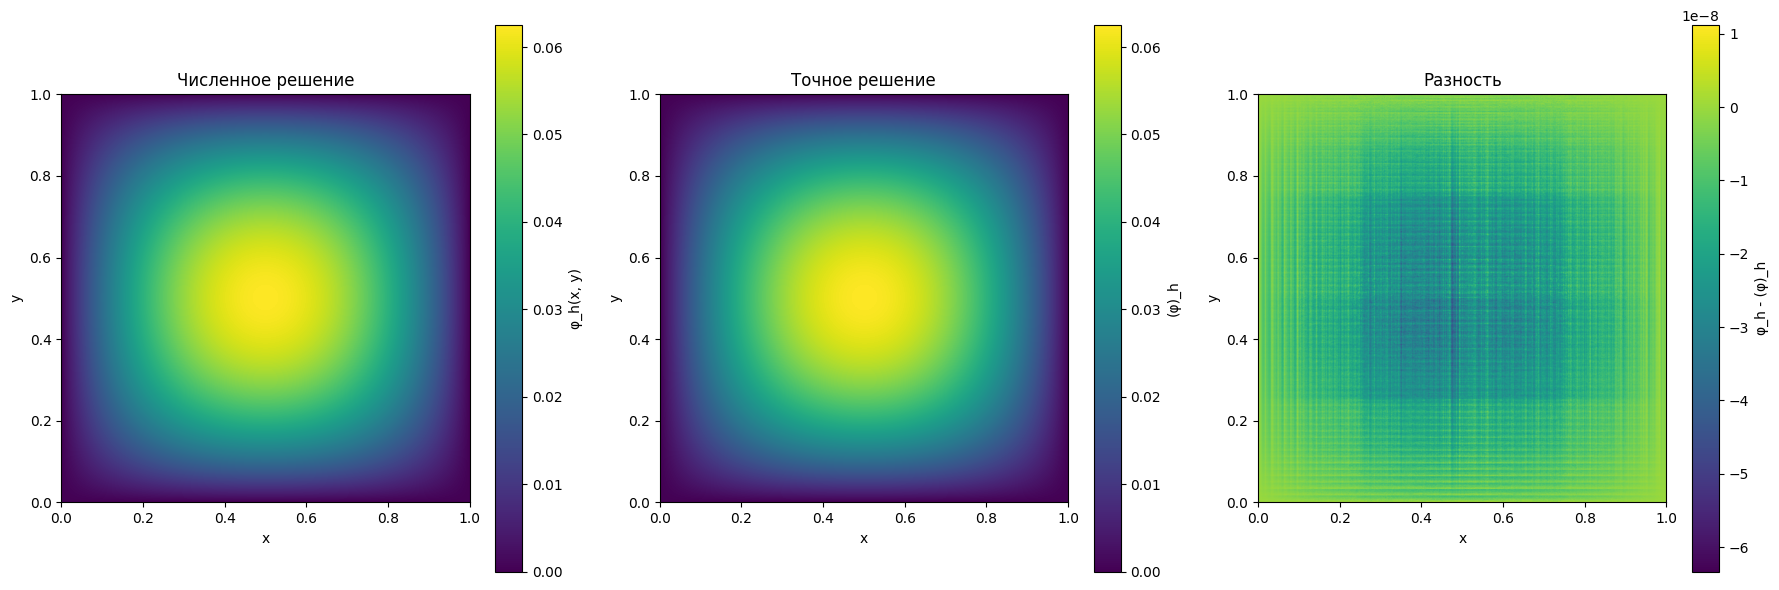

In [11]:
plot_3d_comparison(X.cpu(), Y.cpu(), phi.cpu(), exact_solution.cpu())
plot_imshow_comparison(phi.cpu(), exact_solution.cpu())

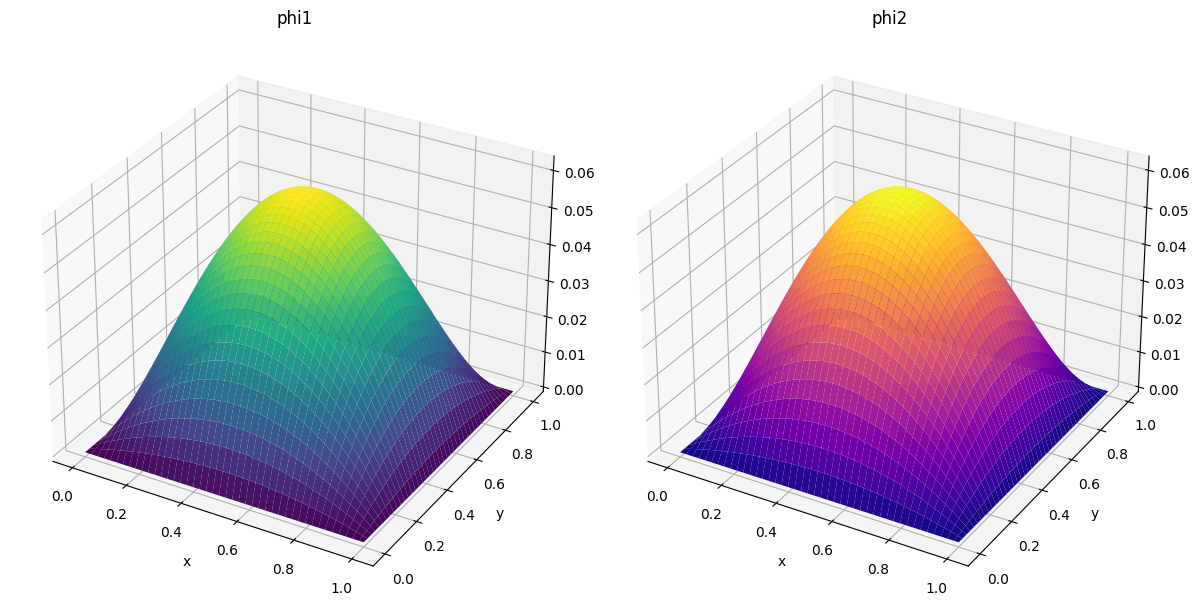

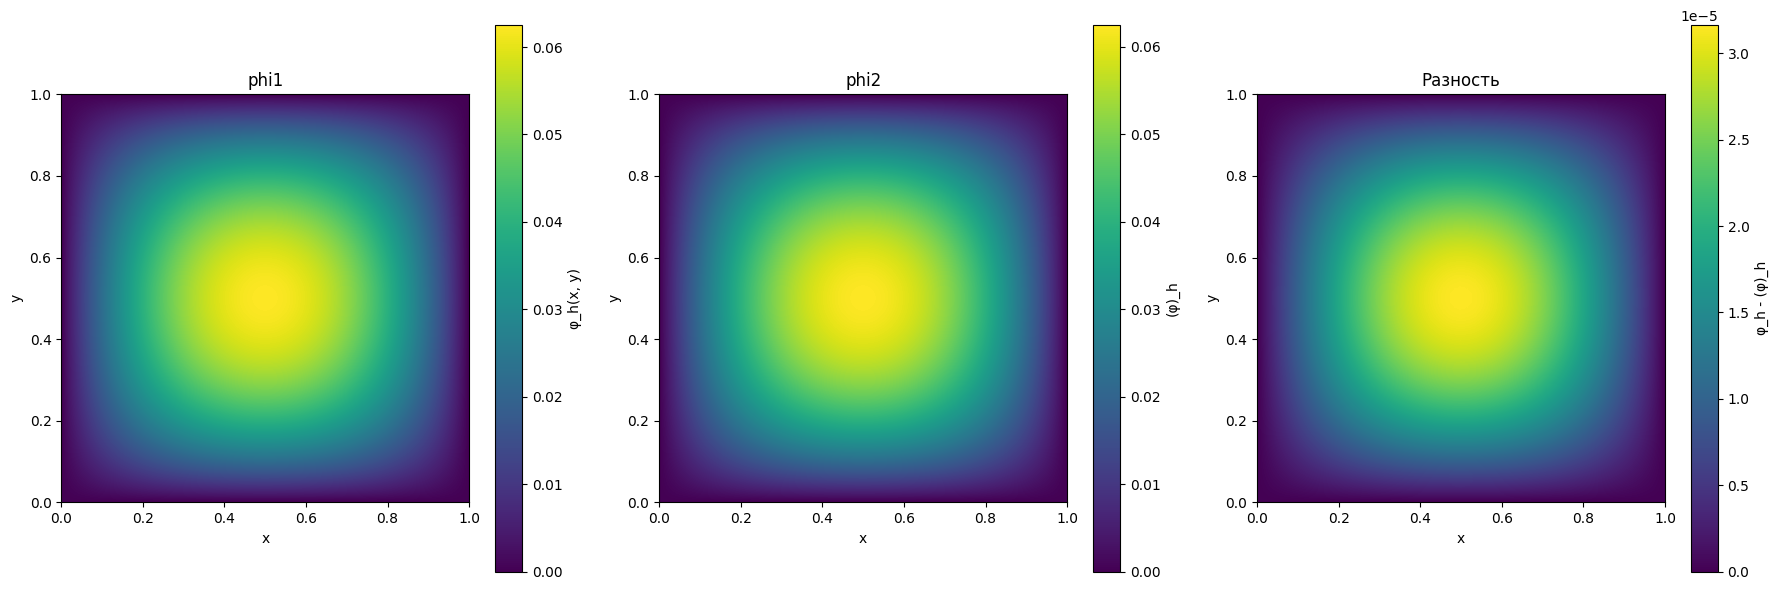

In [8]:
# Метод продолжения по параметру

mu1 = 1
mu2 = 1.01
phi1 = solve_helmholtz(mu1, f, h)
phi2 = solve_helmholtz(mu2, f, h)

plot_3d_comparison(X.cpu(), Y.cpu(), phi1.cpu(), phi2.cpu(), titles= ['phi1', 'phi2'])
plot_imshow_comparison(phi1.cpu(), phi2.cpu(), titles=['phi1', 'phi2'])

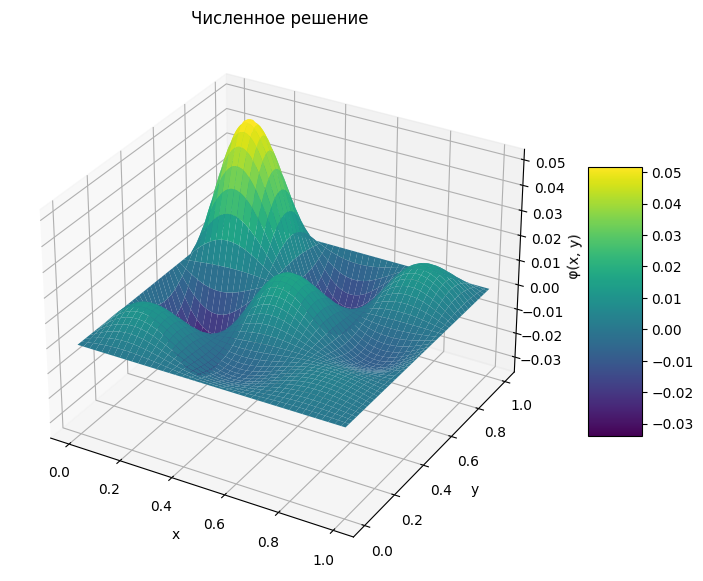

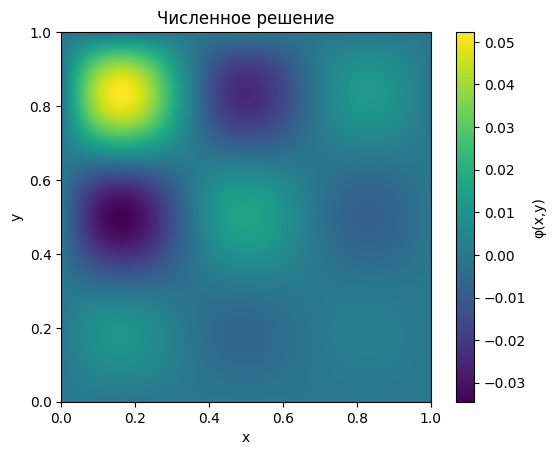

In [9]:
f_test = 20 * torch.sin(3 * np.pi * X) * torch.sin(3 * np.pi * Y) * torch.exp(-2 * X) * torch.log(Y + 1)
phi_test = solve_helmholtz(mu=0, f=f_test, h=h)
plot_3d_solution(X.cpu(), Y.cpu(), phi_test.cpu())
plot_imshow_solution(phi_test.cpu())